In [1]:
import itertools
import numpy as np
from utils import *
from functools import reduce
from numpy.linalg import norm
from typing import List, Tuple
from sympy import solve, Symbol
from collections import defaultdict
from math import log, comb, factorial
from scipy.io import loadmat, savemat
from mindquantum.io.display import BlochScene

np.set_printoptions(precision=15, linewidth=1000)

In [2]:
def num_qudits(state: np.ndarray, dim: int = 2) -> int:
    if state.ndim == 2 and (state.shape[0] == 1 or state.shape[1] == 1):
        state = state.flatten()
    if state.ndim == 2 and state.shape[0] != state.shape[1]:
        raise ValueError(f'Wrong state shape {state.shape}')
    if state.ndim != 1 and state.ndim != 2:
        raise ValueError(f'Wrong state shape {state.shape}')
    if not isinstance(dim, (int, np.int64)):
        raise ValueError(f'Wrong dimension type {dim} {type(dim)}')
    n = state.shape[0]
    nq = round(log(n, dim), 12)
    if nq % 1 != 0:
        raise ValueError(f'Wrong state size {n} is not a power of {dim}')
    return int(nq)


def state_site(state: np.ndarray, dim: int = 2, site: int = 0) -> np.ndarray:
    if not isinstance(dim, (int, np.int64)):
        raise ValueError(f'Wrong dimension type {dim} {type(dim)}')
    if not isinstance(site, (int, np.int64)):
        raise ValueError(f'Wrong dimension type {site} {type(site)}')
    nq = num_qudits(state, dim)
    if site < 0 or site > nq:
        raise ValueError(f'Wrong site index {site} is not in 0 to {nq}')
    ind = defaultdict(list)
    for i in range(dim**nq):
        base = np.base_repr(i, dim).zfill(nq)
        ind[int(base[site])].append(i)
    state_site = np.array([sum(state[ind[i]]) for i in range(dim)])
    state_site /= norm(state_site)
    return state_site


def Majorana_points(points: List[np.ndarray]) -> np.ndarray:
    nq_list = [num_qudits(i) for i in points]
    if len(set(nq_list)) != 1:
        raise ValueError(f'Wrong number of qubits {nq_list} is not equal')
    num = len(points)
    points_list, K_list = [], []
    for ind in itertools.permutations(range(num)):
        points_perm = [points[i] for i in ind]
        points_list.append(reduce(np.kron, points_perm))
        K_perm = 1
        for i, j in enumerate(ind):
            K_perm *= np.inner(points[i].conj(), points[j])
        K_list.append(K_perm)
    K = factorial(num) * sum(K_list)
    state = sum(points_list) / np.sqrt(K)
    return state


def stereographic_projection(z: complex) -> np.ndarray:
    z = complex(z).conjugate()  # Why conjugate?
    abs_z2 = np.abs(z)**2
    coor = [2 * np.real(z), 2 * np.imag(z), abs_z2 - 1] / (abs_z2 + 1)
    return coor


def Majorana_representation(state: np.ndarray, dim: int = 2) -> List[np.ndarray]:
    if dim == 2:
        nq = num_qudits(state)
        qudit = symmetric_decoding(state)
    else:
        nq = dim - 1
        qudit = state
    z = Symbol('z')
    expr = sum([qudit[i] * np.sqrt(comb(nq, i)) * (-z)**i for i in range(nq + 1)])
    root = solve(expr, z)
    coor_list = [stereographic_projection(z) for z in root]
    coor_q0 = np.array([0, 0, 1], dtype=DTYPE)
    if len(coor_list) < nq:
        for _ in range(nq - len(coor_list)):
            coor_list.append(coor_q0)
    return coor_list


def coor_to_angle(coor: np.ndarray) -> Tuple[float]:
    theta = np.arccos(coor[2])
    phi = np.arctan2(coor[1], coor[0])
    return theta, phi


def anlge_to_state(theta: float, phi: float) -> np.ndarray:
    state = [np.cos(theta / 2), np.sin(theta / 2) * np.exp(1j * phi)]
    return np.array(state)


def coor_to_state(coor: np.ndarray) -> np.ndarray:
    return anlge_to_state(*coor_to_angle(coor))

In [ ]:
dim = 3
vec = 1
prepared_dict = {}
for num in range(1, 6):
    for D in [5, 6, 7, 8, 9]:
        prepared_load = loadmat('./data_322/prepared_state_violation.mat')
        prepared_state = prepared_load[f'num{num}_D{D}_vec{vec}'][0]
        nq = num_qudits(prepared_state, dim)
        for site in range(nq):
            prepared_site = state_site(prepared_state, dim, site)
            prepared_coor = Majorana_representation(prepared_site, dim)
            prepared_dict[f'num{num}_D{D}_vec{vec}_site{site+1}'] = prepared_coor
# savemat('./data_322/prepared_coor_violation.mat', prepared_dict)

In [ ]:
dim = 3
target_dict = {}
for num in range(1, 6):
    for D in [5, 6, 7, 8, 9]:
        for vec in range(1, 41):
            target_load = loadmat('./data_322/target_state_violation.mat')
            target_state = target_load[f'num{num}_D{D}_vec{vec}'][0]
            nq = num_qudits(target_state, dim)
            for site in range(nq):
                target_site = state_site(target_state, dim, site)
                target_coor = Majorana_representation(target_site, dim)
                target_dict[f'num{num}_D{D}_vec{vec}_site{site+1}'] = target_coor
            print(f'num{num}_D{D}_vec{vec}')
# savemat('./data_322/target_coor_violation.mat', target_dict)

In [3]:
dim, vec = 3, 40
target_dict, prepared_dict = {}, {}
for num in range(1, 6):
    for D in [5, 6, 7, 8, 9]:
        target_load = loadmat('./data_322/target_state_violation.mat')
        prepared_load = loadmat('./data_322/prepared_state_violation.mat')
        target_state = target_load[f'num{num}_D{D}_vec{vec}'][0]
        prepared_state = prepared_load[f'num{num}_D{D}_vec{vec}'][0]
        nq = num_qudits(target_state, dim)
        for site in range(nq):
            target_site = state_site(target_state, dim, site)
            prepared_site = state_site(prepared_state, dim, site)
            target_coor = Majorana_representation(target_site, dim)
            prepared_coor = Majorana_representation(prepared_site, dim)
            target_dict[f'num{num}_D{D}_vec{vec}_site{site+1}'] = target_coor
            prepared_dict[f'num{num}_D{D}_vec{vec}_site{site+1}'] = prepared_coor
# savemat('./data_322/target_coor_violation.mat', target_dict)
# savemat('./data_322/prepared_coor_violation.mat', prepared_dict)
target_dict, prepared_dict

({'num1_D5_vec40_site1': [array([0.636386250544424, 0.439960548530044, 0.633598655187297]),
   array([0., 0., 1.])],
  'num1_D5_vec40_site2': [array([-0.243937422151596, -0.770479083314168, -0.588945257430088]),
   array([0.494440124359604, 0.375076102292867, 0.784121725825812])],
  'num1_D5_vec40_site3': [array([ 0.063356533188798,  0.992991883952295, -0.09976506456254 ]),
   array([ 0.575538704858363, -0.768781028368612,  0.278802671490892])],
  'num1_D5_vec40_site4': [array([ 0.096692062063221, -0.918717616549447,  0.382895006725949]),
   array([0.572109249242604, 0.79590938222606 , 0.19803853719818 ])],
  'num1_D5_vec40_site5': [array([ 0.222157238890262, -0.822252177172881, -0.523972822141677]),
   array([ 0.447498383093153,  0.649971735058196, -0.614232806641302])],
  'num1_D5_vec40_site6': [array([-0.033213039720517, -0.580272673757329,  0.813744749957285]),
   array([0., 0., 1.])],
  'num1_D5_vec40_site7': [array([-0.030740242537089,  0.411836609981501, -0.910739064808195]),
  

In [4]:
def q(ket: str, dim: int = 2) -> np.ndarray:
    return np.eye(dim**len(ket), dtype=CDTYPE)[int(ket, dim)]


GHZ = q('000') + q('111')
GHZ /= norm(GHZ)
str_ket(GHZ)

a = q('0') + q('1')
b = q('0') + np.exp(1j * 2 * np.pi / 3) * q('1')
c = q('0') + np.exp(1j * 4 * np.pi / 3) * q('1')
GHZ_list = [i / norm(i) for i in [a, b, c]]
for i in GHZ_list:
    str_ket(i)

√2/2¦000⟩
√2/2¦111⟩
[0.707106781186547+0.j 0.               +0.j 0.               +0.j 0.               +0.j 0.               +0.j 0.               +0.j 0.               +0.j 0.707106781186547+0.j]
√2/2¦0⟩
√2/2¦1⟩
[0.707106781186547+0.j 0.707106781186547+0.j]
√2/2¦0⟩
-√2/4+0.6124j¦1⟩
[ 0.707106781186547+0.j                -0.353553390593274+0.612372435695794j]
√2/2¦0⟩
-√2/4-0.6124j¦1⟩
[ 0.707106781186547+0.j                -0.353553390593274-0.612372435695794j]


In [5]:
nq = 2
MP_list = []
np.random.seed(42)
for _ in range(nq):
    theta = np.random.uniform(0, np.pi)
    phi = np.random.uniform(0, 2 * np.pi)
    MP = anlge_to_state(theta, phi)
    MP_list.append(MP)
    print(MP)
state = Majorana_points(MP_list)

coor_list = Majorana_representation(state)
for i in coor_list:
    print(coor_to_state(i))

[0.831870727940561+0.j                0.528571684686074-0.169124410254012j]
[ 0.408657760055634+0.j                -0.742875429229538-0.530221587445609j]
[ 0.408657760055634+0.j                -0.742875429229538-0.530221587445609j]
[0.831870727940561+0.j                0.528571684686074-0.169124410254013j]


[ 0.879406624217145 -0.281379292541047  0.384017816008717] 1.176652485845522 -0.30967114581937
[-0.607163617818621 -0.433358332517329 -0.665997670292624] 2.2996267900669447 -2.521703115254364


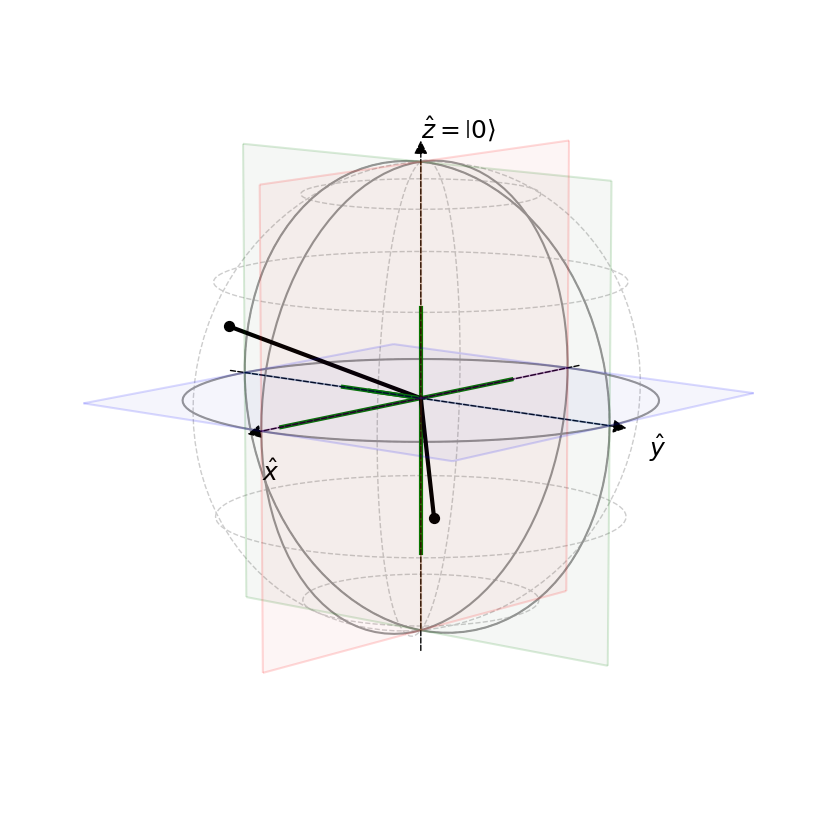

In [6]:
scene = BlochScene()
fig, ax = scene.create_scene()
for MP in MP_list:
    coor = scene.state_to_cor(MP)
    theta, phi = coor_to_angle(coor)
    scene.add_state(ax, MP)
    print(coor, theta, phi)

[-0.607163617818621 -0.43335833251733  -0.665997670292624] 2.299626790066945 -2.5217031152543634
[ 0.879406624217145 -0.281379292541047  0.384017816008717] 1.1766524858455218 -0.3096711458193703


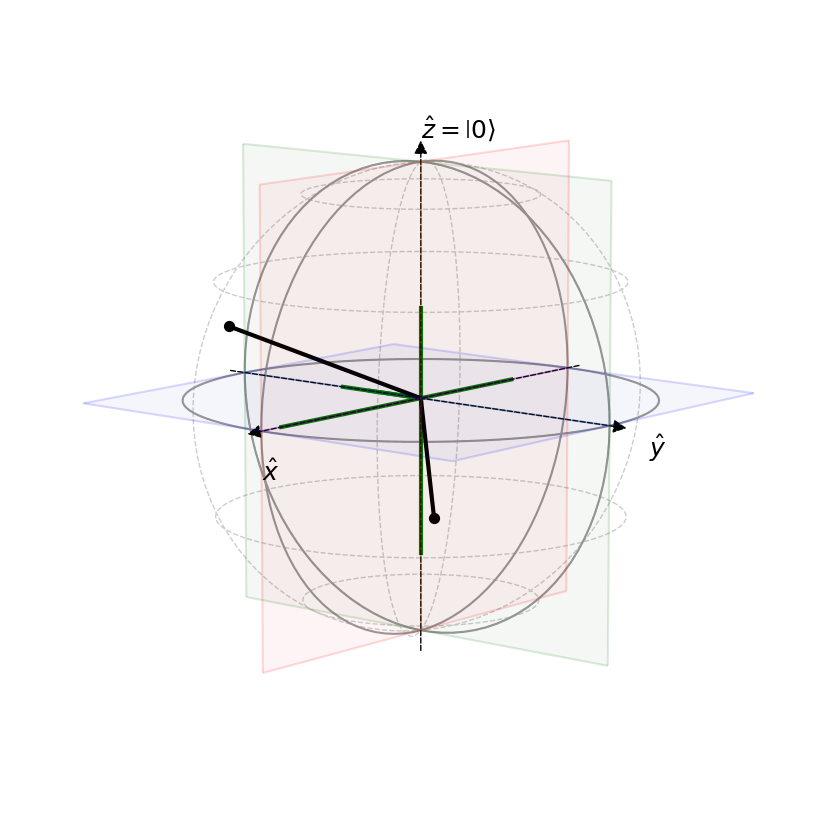

In [7]:
scene = BlochScene()
fig, ax = scene.create_scene()
for coor in coor_list:
    theta, phi = coor_to_angle(coor)
    MP = anlge_to_state(theta, phi)
    scene.add_state(ax, MP)
    print(coor, theta, phi)